# Dependency parsing

In [ ]:
# Load data with identity term matches extracted, tokenized
import pandas as pd

path = '../../data/incels/processed_comments.pkl'
# path = '../data/white_supremacist_identities.pkl'
data = pd.read_pickle(path)
data.info()

In [ ]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['ner'])

In [ ]:
samp = data[data.netmapper_identity_matches.map(lambda x: len(x) > 0)].head(1)
samp

In [ ]:
pd.set_option('display.max_colwidth', None)
test = test.loc[12, 'content']

In [ ]:
doc = nlp(test)
doc

In [ ]:
parse = [tok.dep_ for tok in doc]
parse

In [ ]:
parse[tok_idx]

In [ ]:
[tok.head for tok in doc][tok_idx]

In [ ]:
# Match extracted identities to tokens
from collections import defaultdict

actions_attributes = {} # identity: {'actions': [actions], {'attributes': [attributes]} # replace with separate columns of attributes and actions in exploded df
identity_ctr = defaultdict(int) # keep track of how many of this identity I've seen

for identity in samp.loc[12, 'netmapper_identity_matches']:
    
    # Get identity mention locations
    mention_idx = [i for i, tok in enumerate(doc) if tok.text==identity]
    tok_idx = mention_idx[identity_ctr[identity]]
    
    # Verbs where identity term was the subject
    verbs_subj = [tok.head.text for tok in doc if tok.i==tok_idx \
        in mention_idx and (tok.dep_=='nsubj' or tok.dep_=='agent')]

    # Verbs where identity term was the object
    verbs_obj = [tok.head.text for tok in doc if tok.i==tok_idx and \
        (tok.dep_=='dobj' or tok.dep_=='nsubjpass' or \
        tok.dep_=='dative' or tok.dep_=='pobj')]

    # Adjectives that describe the identity term
    adjs = [tok.text.lower() for tok in doc if tok.head.i == tok_idx and \
        (tok.dep_=='amod' or tok.dep_=='appos' or \
        tok.dep_=='nsubj' or tok.dep_=='nmod')] \
        + [tok.text.lower() for tok in doc if tok.dep_=='attr' and \
            (tok.head.text=='is' or tok.head.text=='was') and \
           any([c.i==tok_idx for c in tok.head.children])]
    
    actions_attributes[identity] = {'actions': verbs_subj + verbs_obj, 'attributes': adjs}
    identity_ctr[identity] += 1
    
actions_attributes

In [ ]:
# Create a list of identity term unique indexes for each identity term list
data['netmapper_identity_matches']

In [ ]:
from collections import defaultdict, Counter

def unique_term_index(l):
    ctr = Counter()
    res = []
    for term in l:
        res.append(ctr[term])
        ctr[term] += 1
    return res

In [ ]:
unique_term_index(['incels', 'incels', 'teen'])

# Aggregate extracted actions and attributes

In [1]:
# Load data with extracted actions and attributes
import pandas as pd

path = '../../data/incels/processed_comments.pkl'
data = pd.read_pickle(path)
data.info()

exp = data.explode(['netmapper_identity_matches', 'actions_attributes'])
# exp.info()

# Group identities
import json

identity_groups_fpath = '../resources/identity_groups.json'
with open(identity_groups_fpath, 'r') as f:
    identity_groups = json.load(f)
print(len(identity_groups))

exp['identity_group'] = exp.netmapper_identity_matches.map(lambda x: identity_groups.get(x, x))
exploded = exp.explode('identity_group') # Count intersectional mentions as a mention in each of their categories
exploded.info()

# %%timeit -n 1 -r 1 # make Counter right away
from collections import Counter

# samp = exploded.sample(int(1e6))
# gped = samp.groupby('identity_group')
gped = exploded.groupby('identity_group')

# Aggregate actions and attribute for different identities
# agg = gped.agg({'actions_attributes': lambda x: {'actions': Counter([action for el in x for action in el['actions']]).most_common(),
#                                                 'attributes': Counter([attr for el in x for attr in el['attributes']]).most_common()},
#                                                'content': 'count'
#                                               })
agg = gped.agg(verbs_subj = pd.NamedAgg(column='actions_attributes', aggfunc=lambda x: Counter([term for el in x for term in el['verbs_subj']]).most_common()),
                verbs_obj = pd.NamedAgg(column='actions_attributes', aggfunc=lambda x: Counter([term for el in x for term in el['verbs_obj']]).most_common()),
                adjs = pd.NamedAgg(column='actions_attributes', aggfunc=lambda x: Counter([term for el in x for term in el['adjs']]).most_common()),
                count = pd.NamedAgg(column='content', aggfunc='count'))
agg.sort_values('count', ascending=False, inplace=True)
agg.info()
# agg[['verbs_subj', 'verbs_obj', 'adjs']].head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6248230 entries, 0 to 6248229
Data columns (total 11 columns):
 #   Column                            Dtype         
---  ------                            -----         
 0   type                              object        
 1   forum                             object        
 2   thread                            object        
 3   username                          object        
 4   date                              object        
 5   content                           object        
 6   parsed_date                       datetime64[ns]
 7   content_orig                      object        
 8   netmapper_identity_matches        object        
 9   netmapper_identity_matches_spans  object        
 10  actions_attributes                object        
dtypes: datetime64[ns](1), object(10)
memory usage: 524.4+ MB
513
<class 'pandas.core.frame.DataFrame'>
Int64Index: 13578886 entries, 0 to 6248229
Data columns (total 12 columns):
 #   

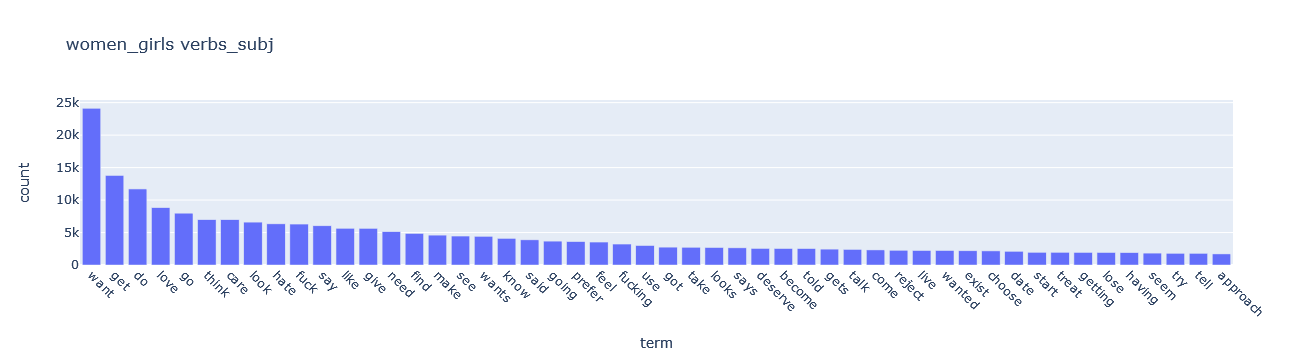

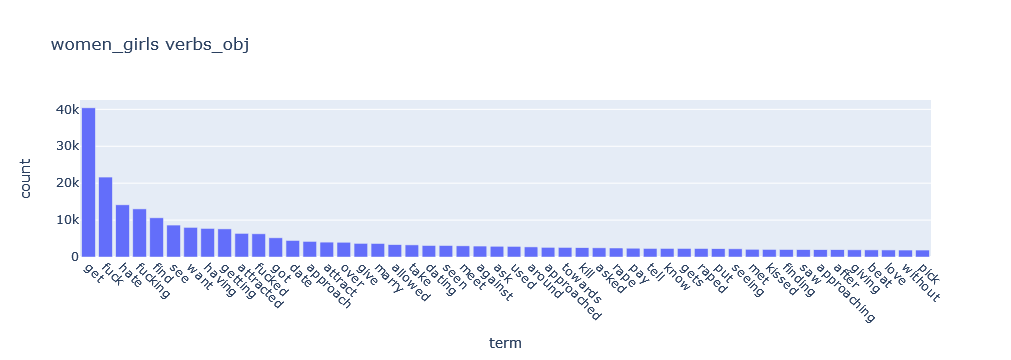

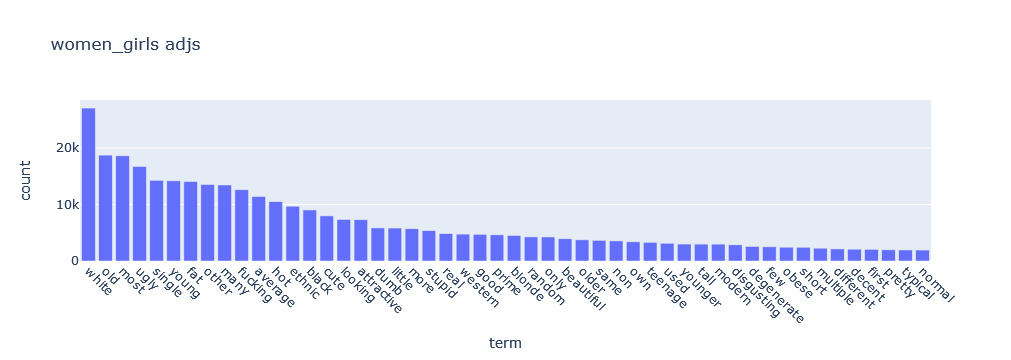

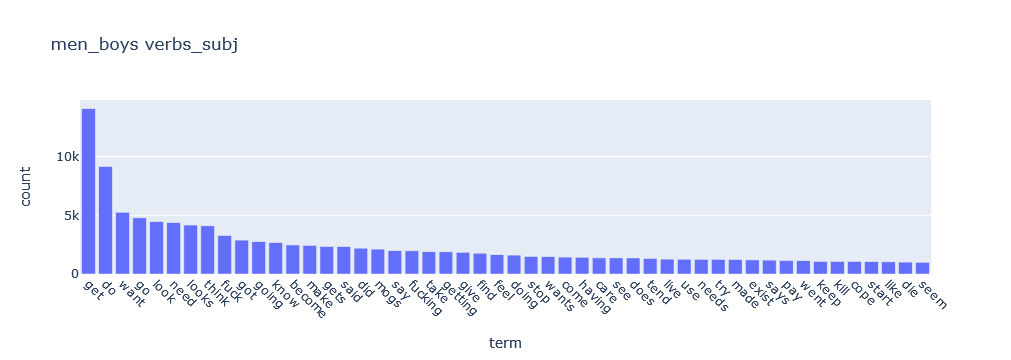

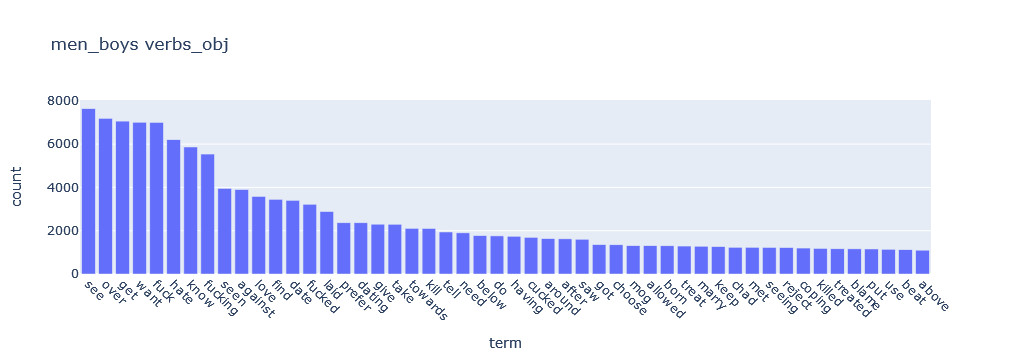

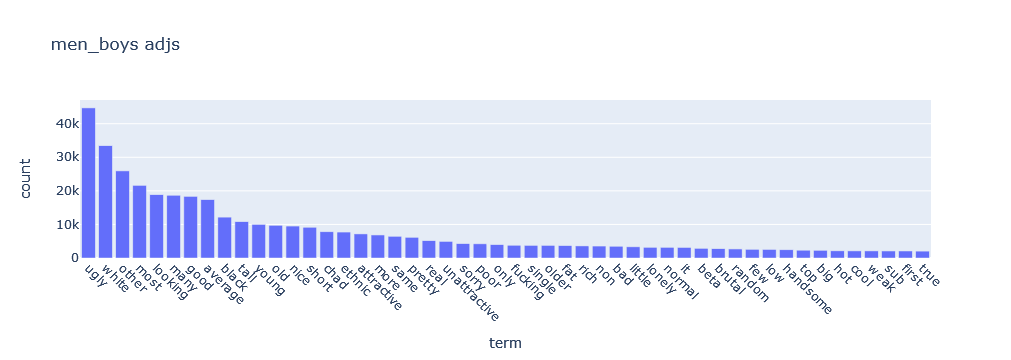

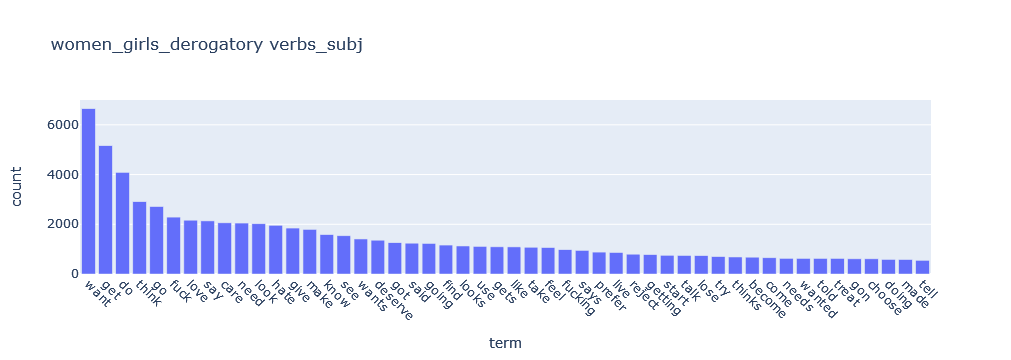

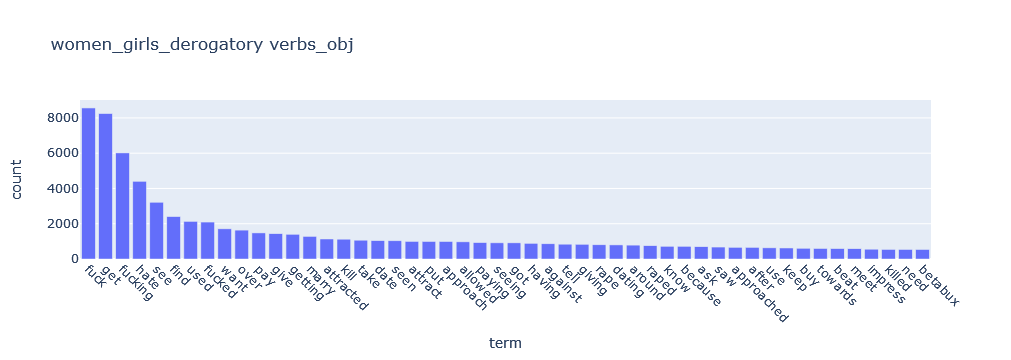

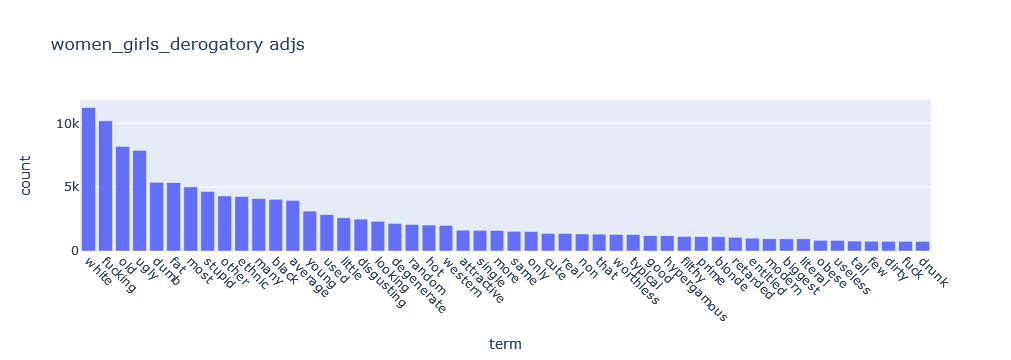

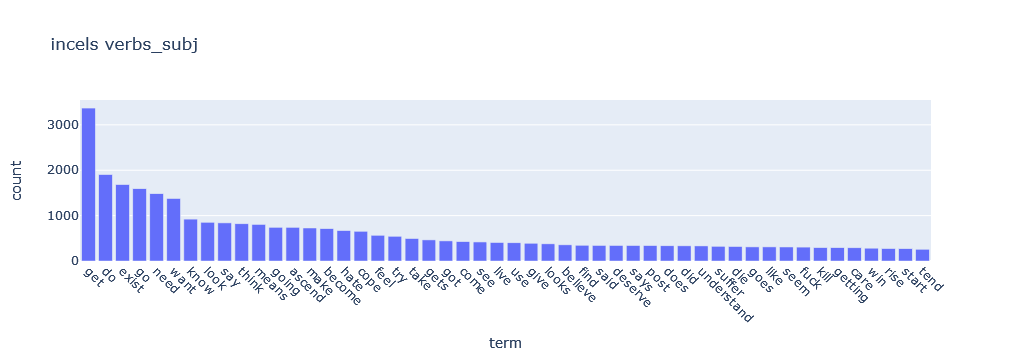

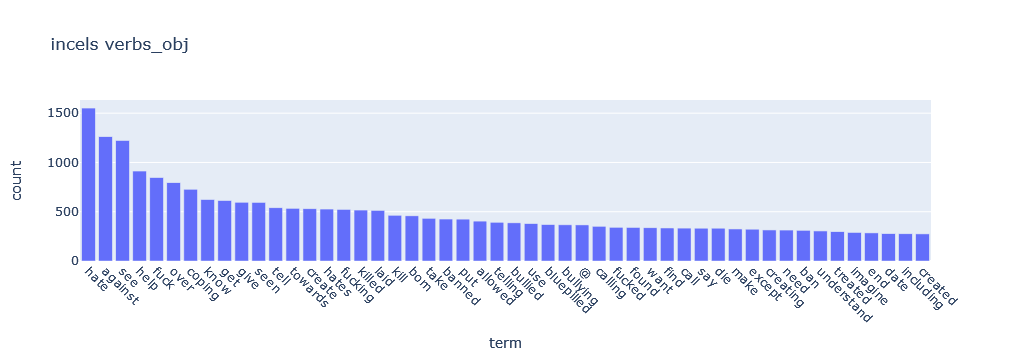

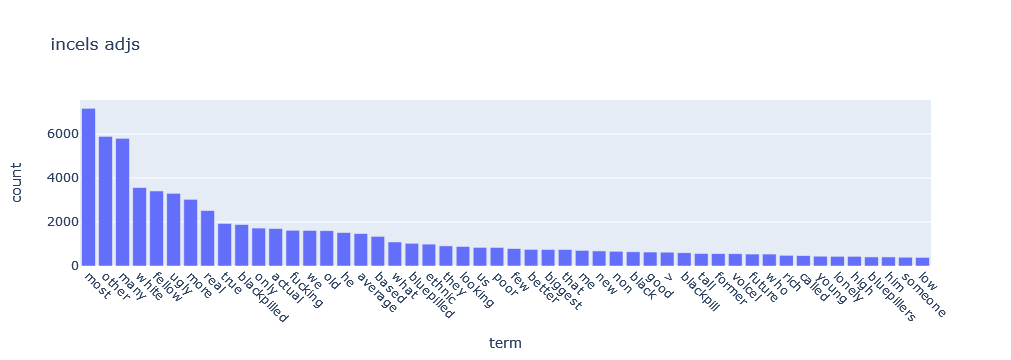

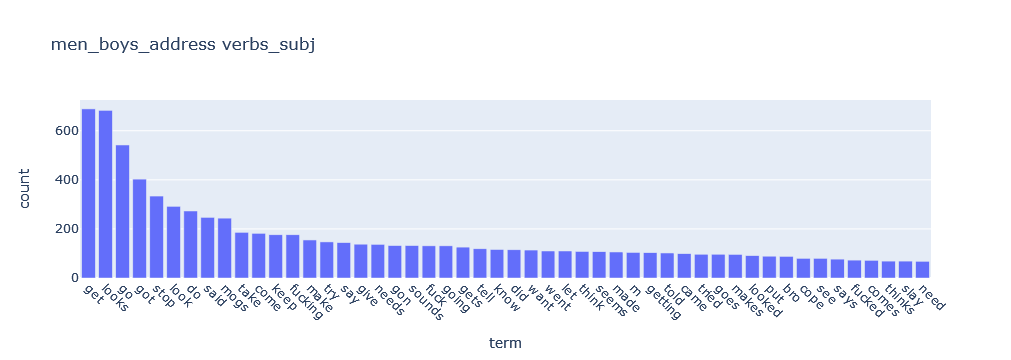

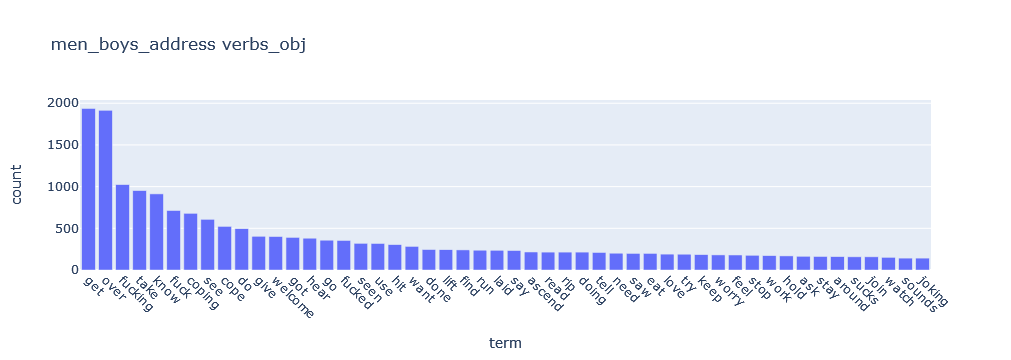

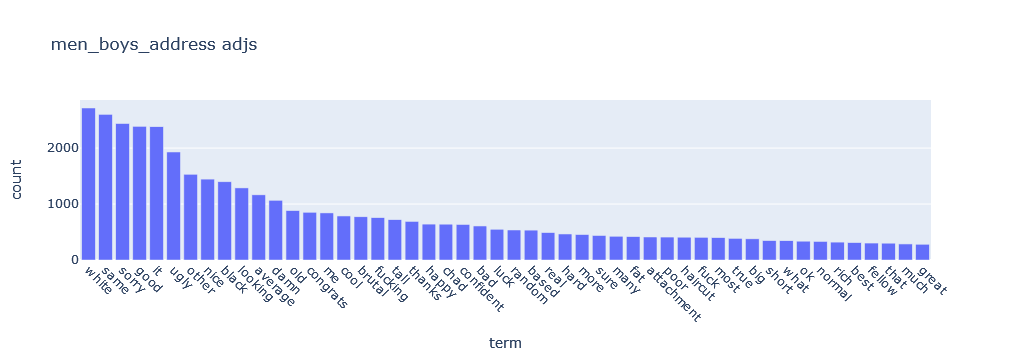

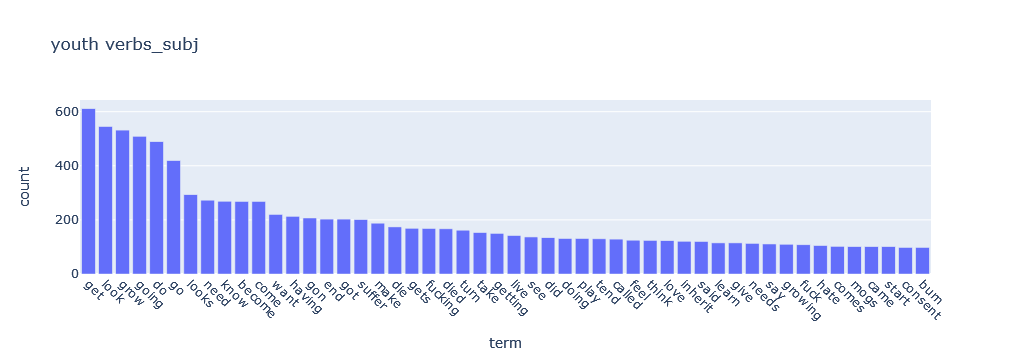

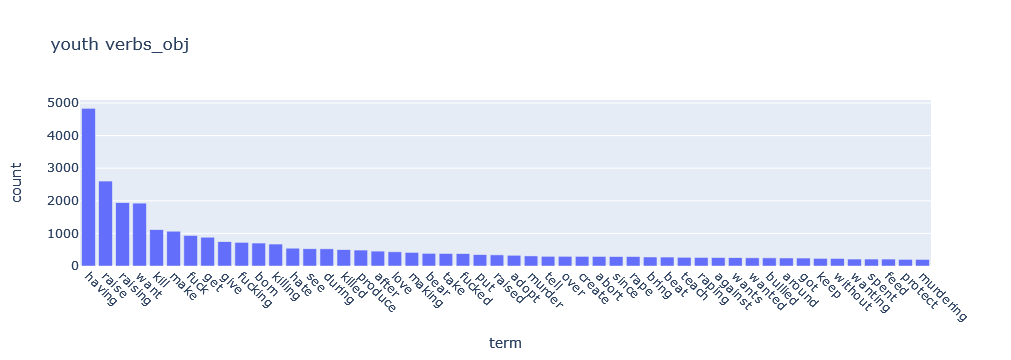

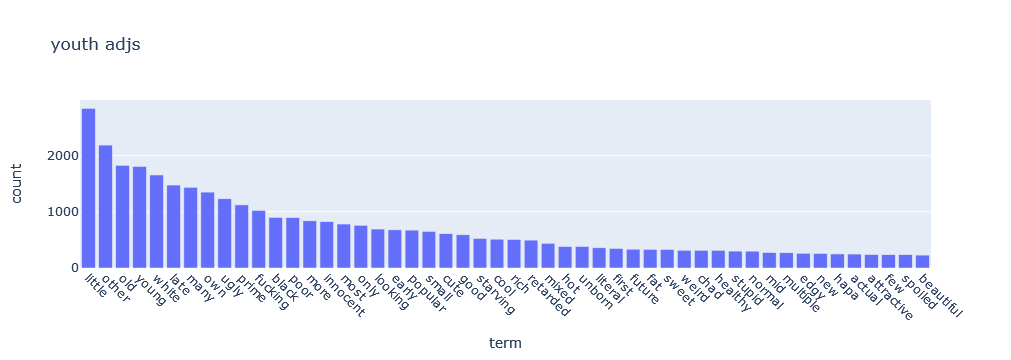

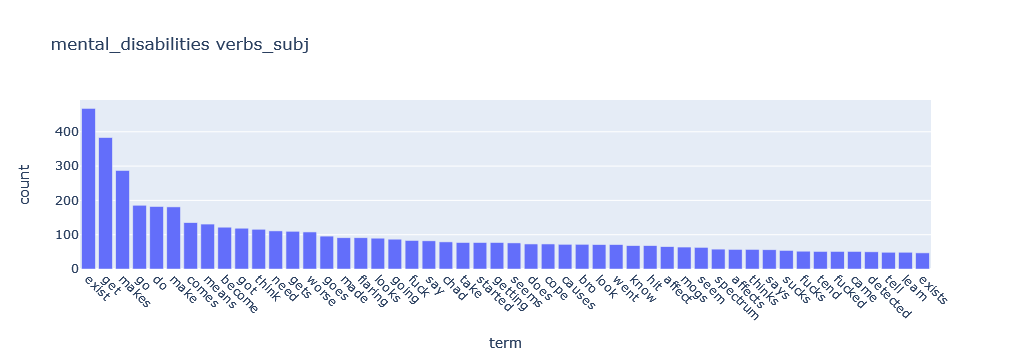

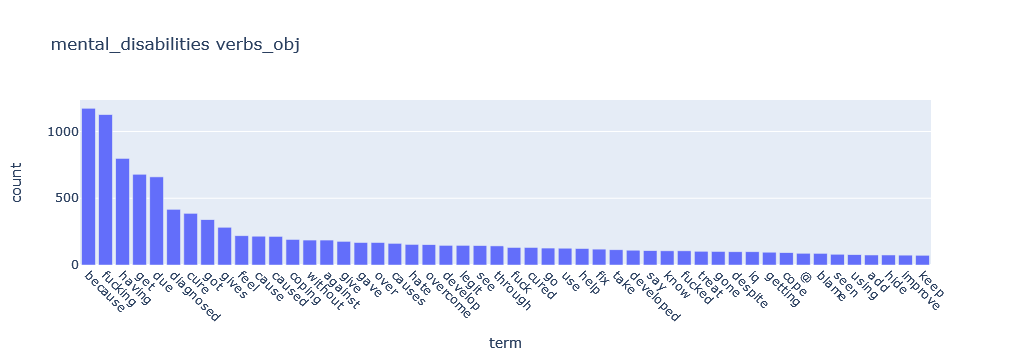

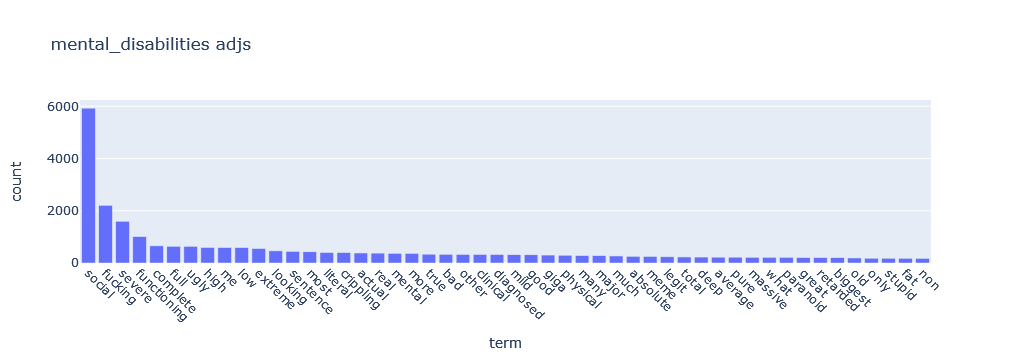

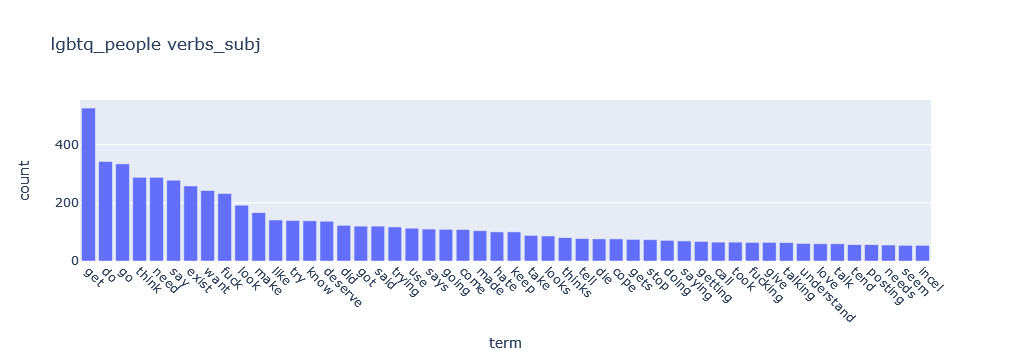

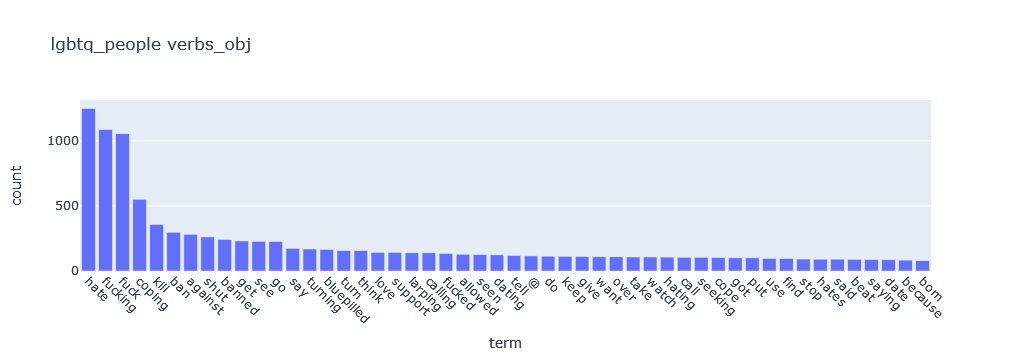

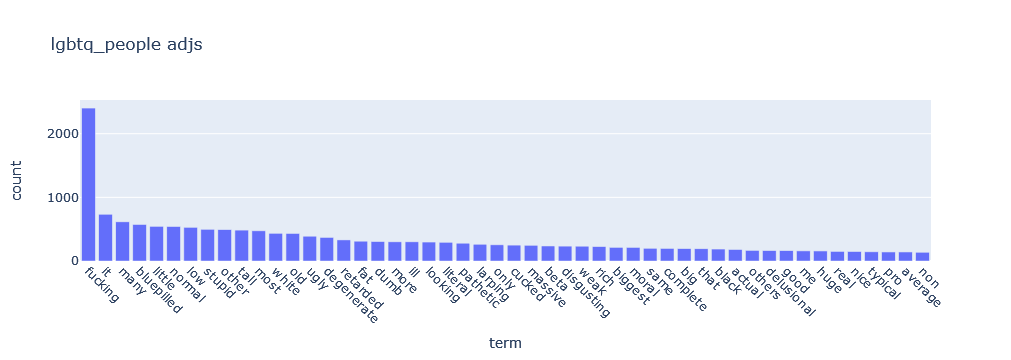

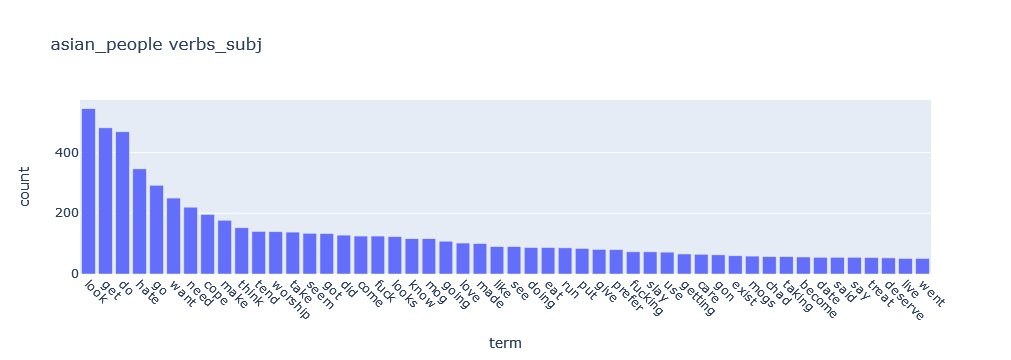

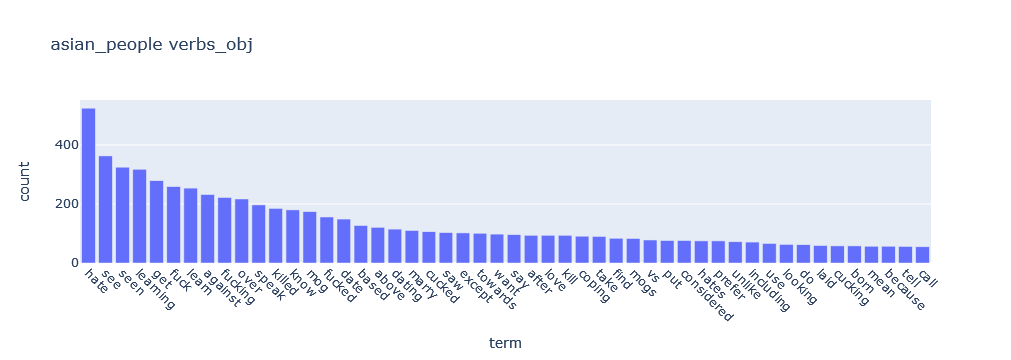

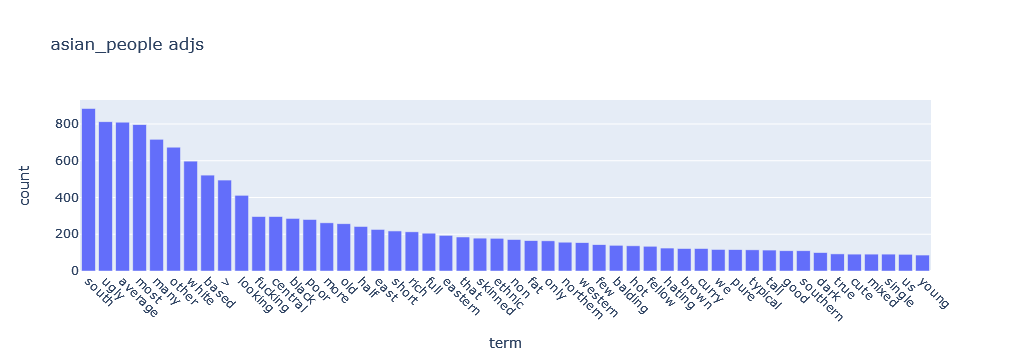

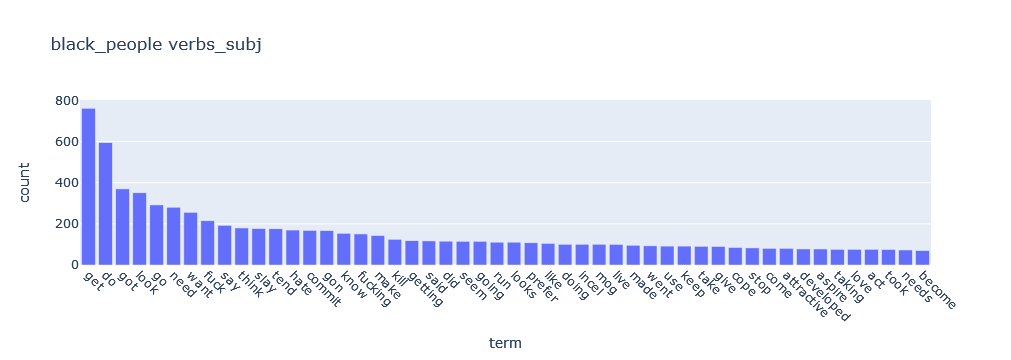

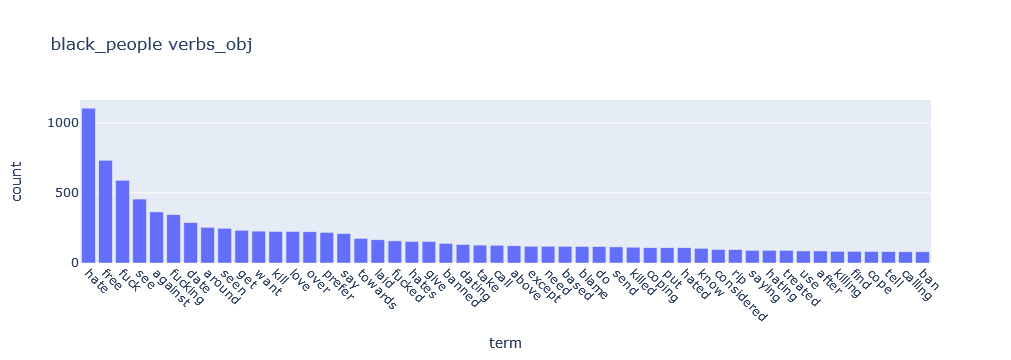

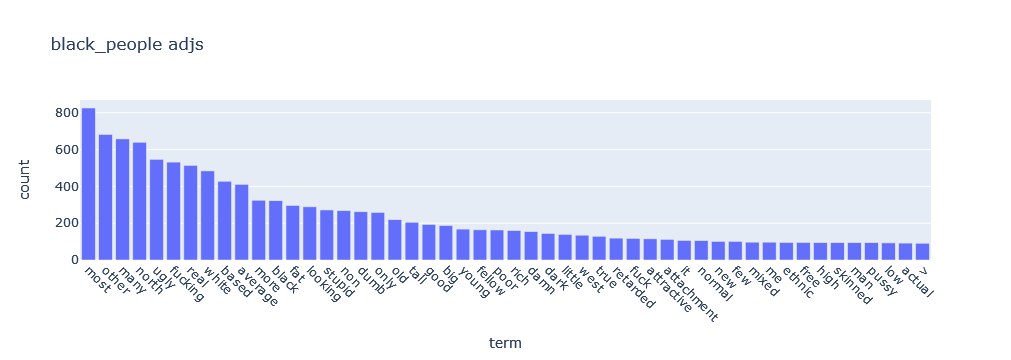

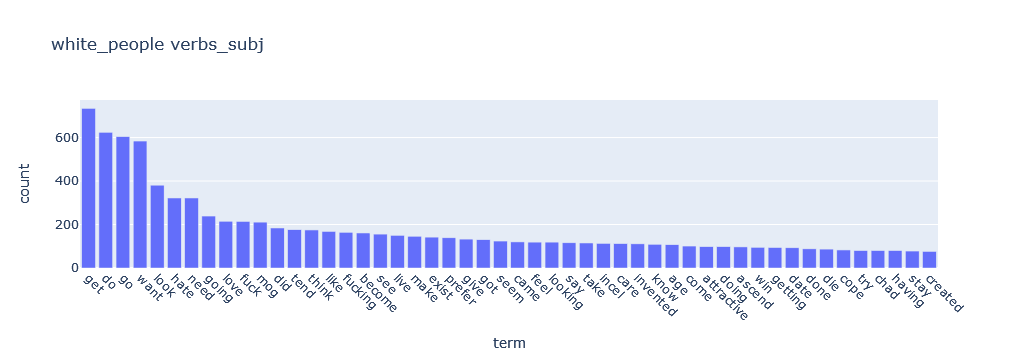

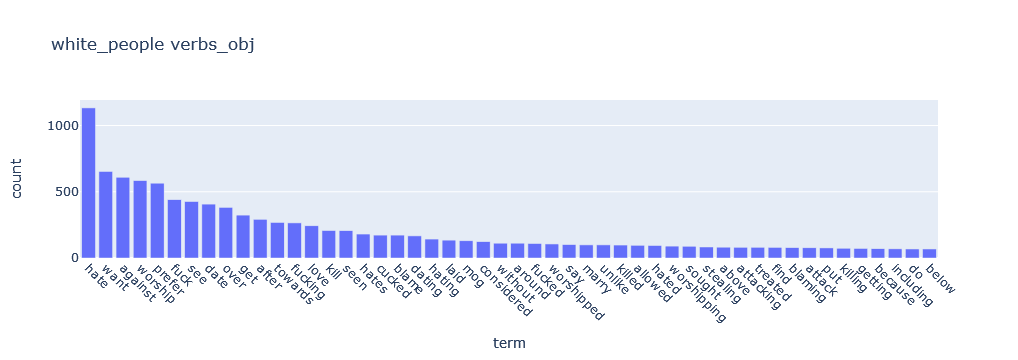

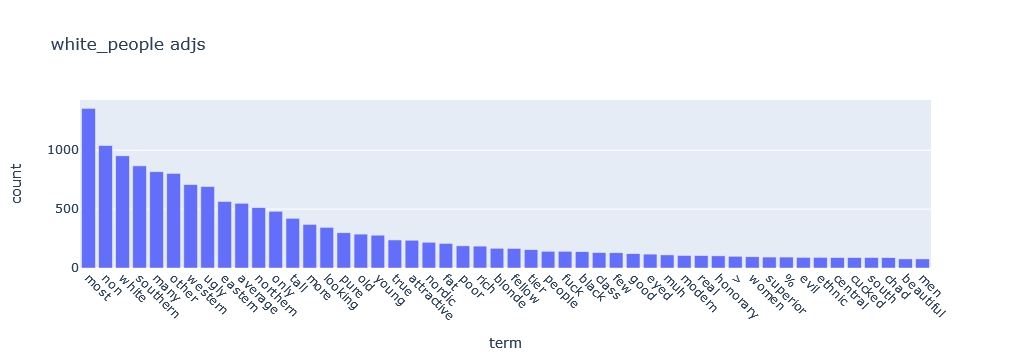

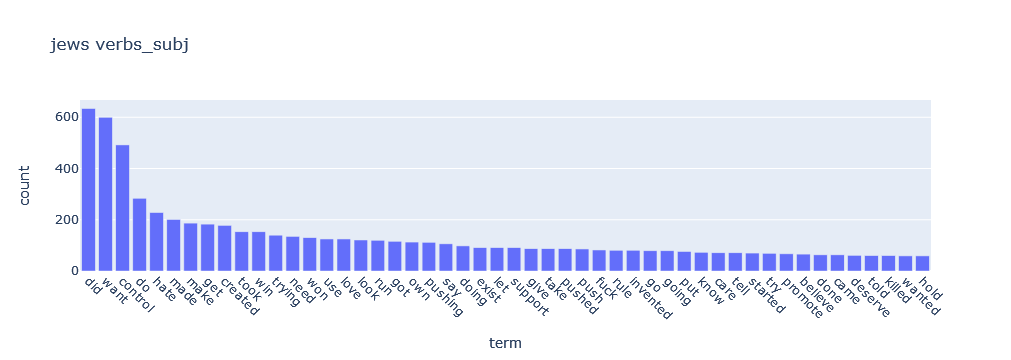

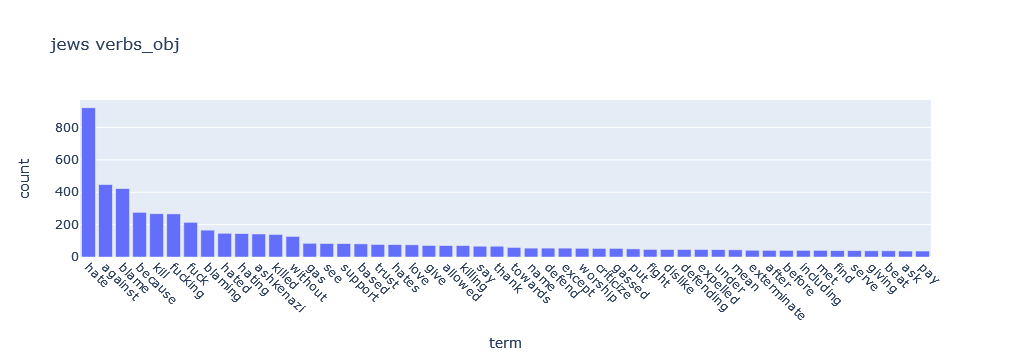

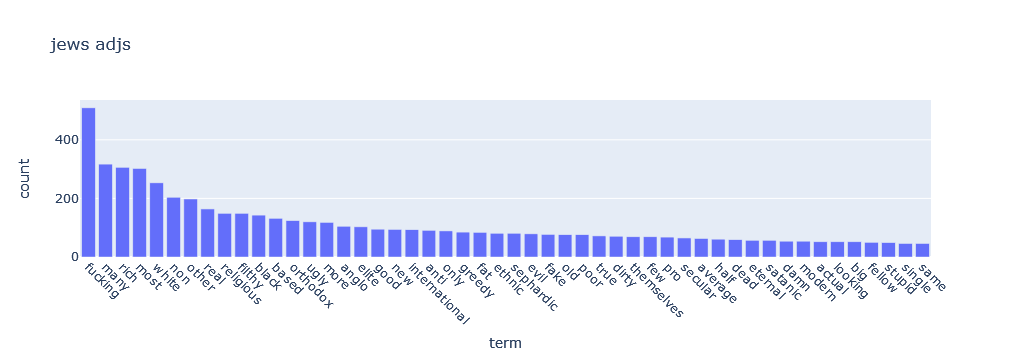

In [6]:
import plotly.express as px

for gp in agg.index[:12]:
    for col in ['verbs_subj', 'verbs_obj', 'adjs']:
        terms, counts = zip(*agg.loc[gp, col][:50])
        fig = px.bar(x=terms, y=counts, title=f'{gp} {col}', labels=dict(x="term", y="count"))
        fig.update_xaxes(tickangle=45)
        # fig.show(config = {'staticPlot': True})
        fig.show()

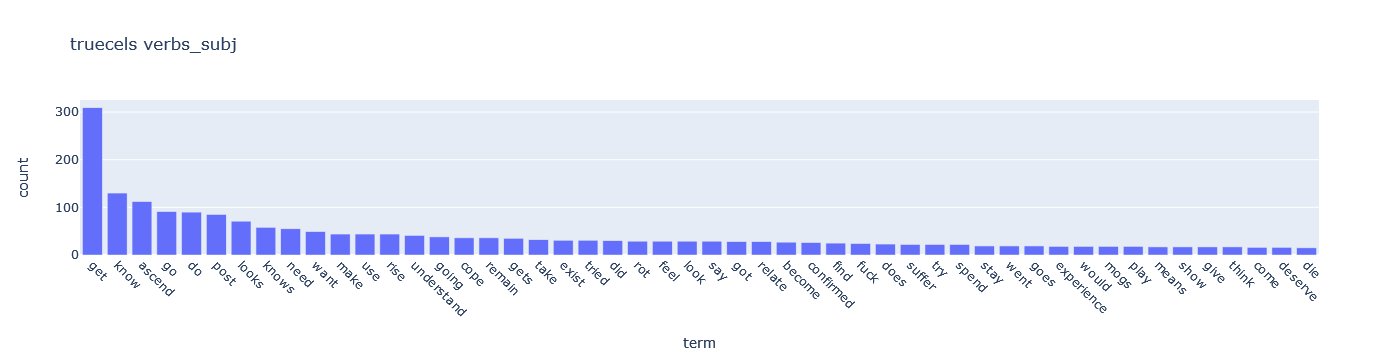

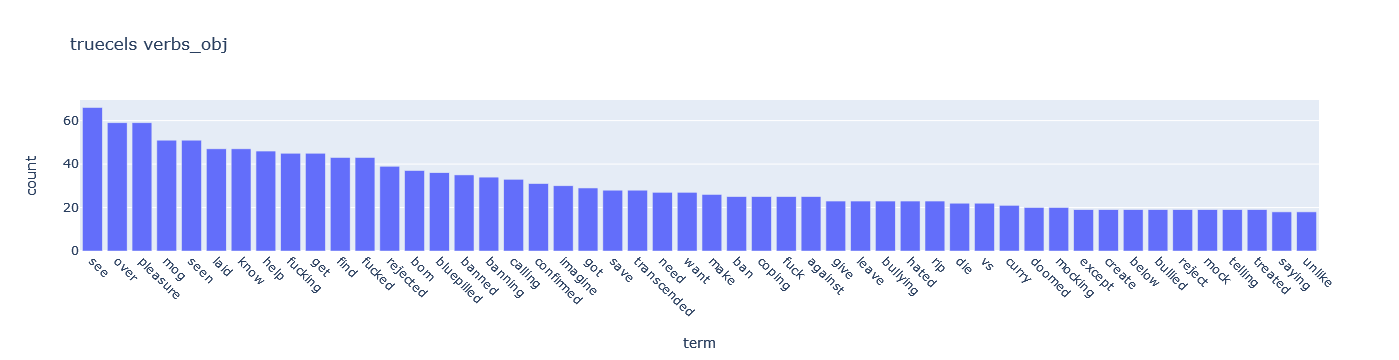

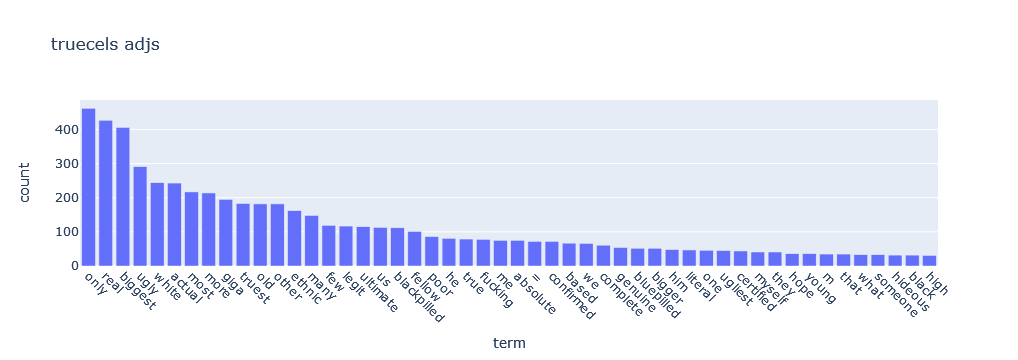

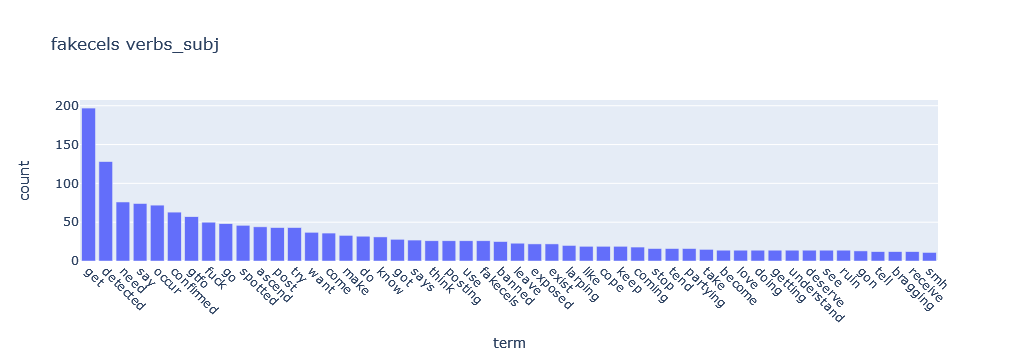

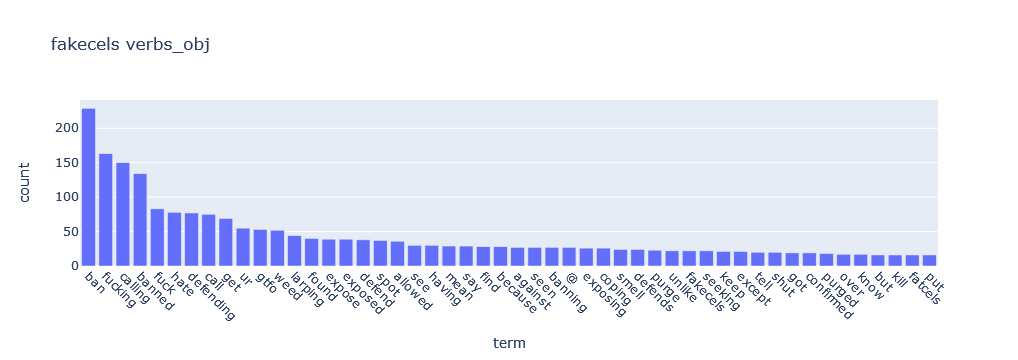

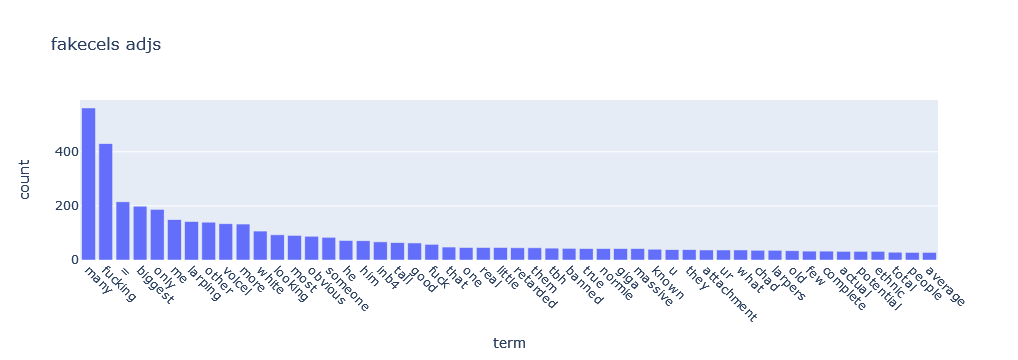

In [7]:
import plotly.express as px

for gp in ['truecels', 'fakecels']:
    for col in ['verbs_subj', 'verbs_obj', 'adjs']:
        terms, counts = zip(*agg.loc[gp, col][:50])
        fig = px.bar(x=terms, y=counts, title=f'{gp} {col}', labels=dict(x="term", y="count"))
        fig.update_xaxes(tickangle=45)
        # fig.show(config = {'staticPlot': True})
        fig.show()

## Make a table for the paper

In [15]:
from IPython.display import display

selected_gps = [gp for gp in agg.index[:12].tolist() if gp not in ['women_girls_derogatory', 'men_boys_address', 'youth']]
formatted = agg[agg.index.isin(selected_gps)].copy()
formatted = pd.melt(formatted.reset_index(), id_vars='identity_group', value_vars=['verbs_subj', 'verbs_obj', 'adjs'], var_name='type', value_name='top_terms')
pd.set_option('display.max_colwidth', None)
formatted[['terms', 'term_counts']] = pd.DataFrame(formatted.top_terms.map(lambda x: list(zip(*x[:10]))).tolist(), index=formatted.index)
formatted = formatted[['identity_group', 'type', 'terms']]
formatted['terms'] = formatted.terms.str.join(', ')
custom_order = dict(reversed(el) for el in enumerate([
    'women_girls', 'men_boys', 'asian_people', 'black_people', 'white_people', 'jews', 'lgbtq_people', 
    'mental_disabilities', 'incels', 'adjs', 'verbs_subj', 'verbs_obj']))
formatted = formatted.sort_values(['identity_group', 'type'], key=lambda x: x.map(custom_order))
names_map = {
    'women_girls': 'Women',
    'men_boys': 'Men',
    'youth': 'Youth',
    'mental_disabilities': 'Neurodiverse',
    'lgbtq_people': 'LGBTQ+',
    'asian_people': 'Asian',
    'black_people': 'Black',
    'white_people': 'White',
    'jews': 'Jews',
    'incels': 'Incels',
    'adjs': '\\textit{Adjs}',
    'verbs_subj': '\\textit{V\\textsubscript{S}}',
    'verbs_obj': '\\textit{V\\textsubscript{O}}'
}
formatted = formatted.replace(names_map)
formatted = formatted.set_index(['identity_group', 'type'])
formatted.index.rename(('\\textbf{Identity}', ''), inplace=True)
formatted.columns = ['\\textbf{Terms}']
display(formatted)
# styled = formatted.style.set_table_styles([
#     {'selector': 'toprule', 'props': ':hline;'},
#     {'selector': 'midrule', 'props': ':hline;'},
#     {'selector': 'bottomrule', 'props': ':hline;'},
# ], overwrite=False)
latex = formatted.style.to_latex(hrules=True, clines='skip-last;data')
latex = latex.replace('\n\cline{2-3}', '').replace(' \cline{2-3}', '').replace('\cline{1-3}\n\bottomrule', '\bottomrule')
# print(styled.to_latex(hrules=True, clines='all;data'))
latex = latex.replace(' &  & \\textbf{Terms} \\\\\n\\textbf{Identity} &  &  ', '\\textbf{Identity} & & \\textbf{Terms} ')
latex = latex.replace('\n\\cline{1-3}\n\\bottomrule', '\n\\bottomrule')
print(latex)
latex

\textbf{Terms}
\textbf{Identity}                                                                                                        
Women             \textit{Adjs}                          white, old, most, ugly, single, young, fat, other, many, fucking
                  \textit{V\textsubscript{S}}                      want, get, do, love, go, think, care, look, hate, fuck
                  \textit{V\textsubscript{O}}       get, fuck, hate, fucking, find, see, want, having, getting, attracted
Men               \textit{Adjs}                       ugly, white, other, most, looking, many, good, average, black, tall
                  \textit{V\textsubscript{S}}                      get, do, want, go, look, need, looks, think, fuck, got
                  \textit{V\textsubscript{O}}              see, over, get, want, fuck, hate, know, fucking, seen, against
Asian             \textit{Adjs}                         south, ugly, average, most, many, other, white, based, >, looking
                  \textit{V\textsubscript{S}}                      look, get, do, hate, go, want, need, cope, make, think
                  \textit{V\textsubscript{O}}         hate, see, seen, learning, get, fuck, learn, against, fucking, over
Black             \textit{Adjs}                      most, other, many, north, ugly, fucking, real, white, based, average
                  \textit{V\textsubscript{S}}                        get, do, got, look, go, need, want, fuck, say, think
                  \textit{V\textsubscript{O}}            hate, free, fuck, see, against, fucking, date, around, seen, get
White             \textit{Adjs}                  most, non, white, southern, many, other, western, ugly, eastern, average
                  \textit{V\textsubscript{S}}                      get, do, go, want, look, hate, need, going, love, fuck
                  \textit{V\textsubscript{O}}            hate, want, against, worship, prefer, fuck, see, date, over, get
Jews              \textit{Adjs}                     fucking, many, rich, most, white, non, other, real, religious, filthy
                  \textit{V\textsubscript{S}}                did, want, control, do, hate, made, make, get, created, took
                  \textit{V\textsubscript{O}}  hate, against, blame, because, kill, fucking, fuck, blaming, hated, hating
LGBTQ+            \textit{Adjs}                   fucking, it, many, bluepilled, little, normal, low, stupid, other, tall
                  \textit{V\textsubscript{S}}                      get, do, go, think, need, say, exist, want, fuck, look
                  \textit{V\textsubscript{O}}          hate, fucking, fuck, coping, kill, ban, against, shut, banned, get
Neurodiverse      \textit{Adjs}                 social, fucking, severe, functioning, complete, full, ugly, high, me, low
                  \textit{V\textsubscript{S}}                  exist, get, makes, go, do, make, comes, means, become, got
                  \textit{V\textsubscript{O}}       because, fucking, having, get, due, diagnosed, cure, got, gives, feel
Incels            \textit{Adjs}                     most, other, many, white, fellow, ugly, more, real, true, blackpilled
                  \textit{V\textsubscript{S}}                      get, do, exist, go, need, want, know, look, say, think
                  \textit{V\textsubscript{O}}               hate, against, see, help, fuck, over, coping, know, get, give

\begin{tabular}{lll}
\toprule
\textbf{Identity} & & \textbf{Terms} \\
\midrule
\multirow[c]{3}{*}{Women} & \textit{Adjs} & white, old, most, ugly, single, young, fat, other, many, fucking \\
 & \textit{V\textsubscript{S}} & want, get, do, love, go, think, care, look, hate, fuck \\
 & \textit{V\textsubscript{O}} & get, fuck, hate, fucking, find, see, want, having, getting, attracted \\
\cline{1-3}
\multirow[c]{3}{*}{Men} & \textit{Adjs} & ugly, white, other, most, looking, many, good, average, black, tall \\
 & \textit{V\textsubscript{S}} & get, do, want, go, look, need, looks, think, fuck, got \\
 & \textit{V\textsubscript{O}} & see, over, get, want, fuck, hate, know, fucking, seen, against \\
\cline{1-3}
\multirow[c]{3}{*}{Asian} & \textit{Adjs} & south, ugly, average, most, many, other, white, based, >, looking \\
 & \textit{V\textsubscript{S}} & look, get, do, hate, go, want, need, cope, make, think \\
 & \textit{V\textsubscript{O}} & hate, see, seen, learning, get, fuck, learn, aga

'\\begin{tabular}{lll}\n\\toprule\n\\textbf{Identity} & & \\textbf{Terms} \\\\\n\\midrule\n\\multirow[c]{3}{*}{Women} & \\textit{Adjs} & white, old, most, ugly, single, young, fat, other, many, fucking \\\\\n & \\textit{V\\textsubscript{S}} & want, get, do, love, go, think, care, look, hate, fuck \\\\\n & \\textit{V\\textsubscript{O}} & get, fuck, hate, fucking, find, see, want, having, getting, attracted \\\\\n\\cline{1-3}\n\\multirow[c]{3}{*}{Men} & \\textit{Adjs} & ugly, white, other, most, looking, many, good, average, black, tall \\\\\n & \\textit{V\\textsubscript{S}} & get, do, want, go, look, need, looks, think, fuck, got \\\\\n & \\textit{V\\textsubscript{O}} & see, over, get, want, fuck, hate, know, fucking, seen, against \\\\\n\\cline{1-3}\n\\multirow[c]{3}{*}{Asian} & \\textit{Adjs} & south, ugly, average, most, many, other, white, based, >, looking \\\\\n & \\textit{V\\textsubscript{S}} & look, get, do, hate, go, want, need, cope, make, think \\\\\n & \\textit{V\\textsubscr

## Look into examples use of actions, attributes

In [74]:
gp = 'fakecels'
term = '='
field = 'adjs'
# field = 'verbs_subj'
# field = 'verbs_obj'

pd.set_option('display.max_colwidth', None)
crit = (exploded.identity_group == gp) & (exploded.actions_attributes.map(lambda x: term in x[field] if isinstance(x, dict) else False))
exploded.loc[crit, ['identity_group', 'content', 'actions_attributes']].sample(10)

,identity_group,content,actions_attributes
426596,fakecels,"i 'm not saying it 's impossible for something like that to happen , i 'm saying this specific one is a larp . gotcha . anyway , larp or not , tall + big dick = fakecel . suicide fuel in its finest form","{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['dick', '=']}"
1655518,fakecels,"maaan , that could be something good , because someone saw you as a sexual partner . that means that you are not ugly ! . go out and talk to a femoid , for sure she will suck your dick right there ! ! trust in me molested guy = fakecel by the way","{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['=']}"
1018181,fakecels,this is the same level of cope as the thread where talking to women = fakecel how would this be a cope ? how am i supposed to feel better ?,"{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['=', 'level']}"
646236,fakecels,real everyone gets matches on tinder because there are many bots and some girls just swipe right on everyone for dopamine boost when they see thousands of matches daily do 1000 swipes with a blackops2cel and i guarantee he will get 10 matches he 's literally chadlite when not bloated view attachment 289432 was this a fatcel ? fatcel = fakecel mostly,"{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['=']}"
1264187,fakecels,the poster said santa cruzz and one guy has a santa cruz hoodie on no bbcs bbc = fakecel xdd,"{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['=']}"
3325944,fakecels,"a white can fuck any race he wants , whitecel = = fakecel","{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['=']}"
800672,fakecels,"idk , does it matter ? there is 10x more fakecels than there is foid here . you just see what he posts i guess some people got banned for low iq posts where they exposed themselves . ok you are getting surgeries and are you going to seamaxx after or no ? not willing to locationmaxx = 100 % volcel / fakecel . volcel definition = having the ability to have sex but refusing to do so . it 's pretty clear to me tbh . also cool pemaxxing i tried doing it but i got bored real quick ngl . i 'm gon na try to ascend locally first , and then i will consider locationmaxxing","{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['locationmaxx', '=', '%', 'volcel']}"
2360308,fakecels,"ca nt take her bitching anymore , i ve been ldaring for 2 weeks now because no school and while my sisters been going out and probably getting railed by chad ( i do nt like even thinking about it tbh ) i ve been just sitting home sleeping , watching anime and playing vidya , i do nt even care to clean my room , wash the dishes after i eat or shower , i m in full on ldar mode and my mom is giving me shit for it every time she comes from work "" wtf you ve been just playing video games since you started your break , you need to get some friends how are you gon na go through life alone , what are you gon na do once were gone ? "" like wtf am i supposed to do , its over , what s the point of even having friends when i m unemployed with no car , no gf and sub3 , having freinds = fakecel in my book , its impossible for me to make friends when i m this disadvantaged , i do nt think she understands that tho does anyone else have to deal with their parents like this ?","{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['=']}"
2224180,fakecels,"incels.is banned me | looksmax.me - men 's self - improvement & aesthetics i truly enjoyed that site , however i got banned because i told them that i am a mentalcel chad . i think this is excessive and now i m permabanned this was a year ago banned my ass . reeeee . looksmax.me you 've claimed to have slept with multiple girls , why were you even there then ? he 's also a bluepilled cherrypicker who makes threads about "" muh ugly guys get girls "" . i 've said it before and i 'll say it again : bluepilled / cherrypicker + "" mentalcel "" + average looking or better = fakecel this formula has held true time and time again .","{'verbs_subj': [], 'verbs_obj': [], 'adjs': ['=']}"
7

# PMI 
To find most associated words with different identity terms

## Load, process data, calculate cooccurrences
Should eventually be put into a script to be automatically run

In [34]:
# Load data with extracted actions and attributes
import pandas as pd

path = '../../data/incels/processed_comments.pkl'
data = pd.read_pickle(path)
data.info()

exp = data.explode(['netmapper_identity_matches', 'actions_attributes'])
# exp.info()

# Group identities
import json

identity_groups_fpath = '../resources/identity_groups.json'
with open(identity_groups_fpath, 'r') as f:
    identity_groups = json.load(f)
print(len(identity_groups))

exp['identity_group'] = exp.netmapper_identity_matches.map(lambda x: identity_groups.get(x, x))
exploded = exp.explode('identity_group') # Count intersectional mentions as a mention in each of their categories
exploded.info()

# %%timeit -n 1 -r 1 # make Counter right away
from collections import Counter

# samp = exploded.sample(int(1e6))
# gped = samp.groupby('identity_group')
gped = exploded.groupby('identity_group')

In [42]:
# Aggregate actions and attribute for different identities
# agg = gped.agg({'actions_attributes': lambda x: {'actions': Counter([action for el in x for action in el['actions']]).most_common(),
#                                                 'attributes': Counter([attr for el in x for attr in el['attributes']]).most_common()},
#                                                'content': 'count'
#                                               })
stops = ['we', 'that', '='] # custom stops for not having to wait to re-run everything
agg = gped.agg(verbs_subj = pd.NamedAgg(column='actions_attributes', aggfunc=lambda x: Counter([term for el in x for term in el['verbs_subj'] if term not in stops]).most_common()),
                verbs_obj = pd.NamedAgg(column='actions_attributes', aggfunc=lambda x: Counter([term for el in x for term in el['verbs_obj'] if term not in stops]).most_common()),
                adjs = pd.NamedAgg(column='actions_attributes', aggfunc=lambda x: Counter([term for el in x for term in el['adjs'] if term not in stops]).most_common()),
                count = pd.NamedAgg(column='content', aggfunc='count'))
agg.sort_values('count', ascending=False, inplace=True)
agg.info()
# agg[['verbs_subj', 'verbs_obj', 'adjs']].head()

<class 'pandas.core.frame.DataFrame'>
Index: 6481 entries, women_girls to sketcher
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   verbs_subj  6481 non-null   object
 1   verbs_obj   6481 non-null   object
 2   adjs        6481 non-null   object
 3   count       6481 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 253.2+ KB


In [54]:
selected_gps = [gp for gp in agg.index[:12].tolist() if gp not in ['women_girls_derogatory', 'men_boys_address', 'youth']] + ['truecels', 'fakecels']
selected_gps

selected_agg = agg.loc[selected_gps]
selected_agg.info()

# Count needed totals
from collections import Counter

cooccurrences = {} # relation: {(identity_group, word): n_times_co-occurs, ...}
freqs = {}
word_freqs = {} # relation: {word: n_times_occurs_with_any_identity}
total_combinations = Counter() # total # label-word matches (total words)
# freq_threshold = 1000
freq_threshold = 100

cols = ['verbs_subj', 'verbs_obj', 'adjs']

# First pass to get total word counts
for col in cols:
    freqs[col] = Counter()
    for index, row in selected_agg.iterrows():
        for term, count in row[col]:
            # cooccurrences[col][(index, term)] = count
            freqs[col][term] += count
            # total_combinations[col] += count
            
# Filter by frequency
word_freqs = {col: {term: count for term, count in freqs[col].items() if count >= freq_threshold} for col in cols}
label_freqs = {col: {gp: len(selected_agg.loc[gp][col]) for gp in selected_agg.index} for col in cols}
            
# Second pass to filter these by frequency
for col in cols:
    cooccurrences[col] = Counter()
    for index, row in selected_agg.iterrows():
        cooccurrences[col].update({(index, term): count for term, count in row[col] if term in word_freqs[col]})
        total_combinations[col] = sum(word_freqs[col].values())
    print(f'{col}: {len(cooccurrences[col])}')

from operator import itemgetter
import math
import pdb

def pmi(words, label_freqs, word_freqs, cooccurrences, n):
    """ Args:
            words: query tuple of (label, word)
            label_freqs: dict of label: count
            word_freqs: dict of word: count
            cooccurrences: dict of (label, word): count
            n: number of possible occurrences (number of words or bigrams in the doc)
    """
    numerator = n * cooccurrences[words]
    if numerator == 0:
        return 0
    denominator = label_freqs[words[0]] * word_freqs[words[1]]
    return math.log(numerator/denominator, 2)

def npmi(words, label_freqs, word_freqs, cooccurrences, n):
    """ Normalized pointwise mutual information
        Args:
            words: query tuple of (label, word)
            label_freqs: dict of label: count
            word_freqs: dict of word: count
            cooccurrences: dict of (label, word): count
            n: number of possible occurrences (number of words or bigrams in the doc)
    """
    numerator = pmi(words, label_freqs, word_freqs, cooccurrences, n)
    denominator = -1 * math.log(cooccurrences[words]/n, 2)
    return numerator/denominator

def pmi2(words, label_freqs, word_freqs, cooccurrences, n):
    return pmik(words, label_freqs, word_freqs, cooccurrences, n, 2)

def pmi3(words, label_freqs, word_freqs, cooccurrences, n):
    return pmik(words, label_freqs, word_freqs, cooccurrences, n, 3)

def pmik(words, label_freqs, word_freqs, cooccurrences, n, k):
    """ Args:
            words: query tuple of (label, word)
            label_freqs: dict of label: count
            word_freqs: dict of word: count
            cooccurrences: dict of (label, word): count
            n: number of possible occurrences (number of words or bigrams in the doc)
            k: type of pmik/exponent to use (for example 2 for pmi2 or 3 for pmi3)
    """
    numerator = (cooccurrences[words]/n) ** k
    denominator = (label_freqs[words[0]]/n) * (word_freqs[words[1]]/n)
    return math.log(numerator/denominator, 2)

def top_pmi(word, label_freqs, word_freqs, cooccurrences, n, calculation='pmi'):
    """ 
            words: query tuple of (label, word)
            label_freqs: dict of label: count
            word_freqs: dict of word: count
            cooccurrences: dict of (label, word): count
            n: number of possible occurrences (number of words or bigrams in the doc)
            calculation: type of pmi to run out of {'pmi', 'npmi', 'pmi2', 'pmi3'}
    """
    # Returns top co-occurring words with a specified word based on PMI
    fn = globals()[calculation]
    
    cooccurring_words = []
    
    pairs = [pair for pair in cooccurrences.keys() if word in pair and pair != (word, word)]  # all words that co-occur
    
    for pair in pairs:
        other_word = [w for w in pair if w != word][0]
        cooccurring_words.append((other_word, fn(pair, label_freqs, word_freqs, cooccurrences, n)))
        
    return sorted(cooccurring_words, key=itemgetter(1), reverse=True)

<class 'pandas.core.frame.DataFrame'>
Index: 11 entries, women_girls to fakecels
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   verbs_subj  11 non-null     object
 1   verbs_obj   11 non-null     object
 2   adjs        11 non-null     object
 3   count       11 non-null     int64 
dtypes: int64(1), object(3)
memory usage: 440.0+ bytes
verbs_subj: 8489
verbs_obj: 9291
adjs: 9535


## Make tables for the paper

In [61]:
calculation = 'pmi3'

for col in cols:
    selected_agg[f'{calculation}_top_{col}'] = selected_agg.index.map(
        lambda gp: ', '.join([el[0] for el in top_pmi(gp, label_freqs[col], word_freqs[col], cooccurrences[col], total_combinations[col], calculation=calculation)[:20]]))
selected_agg.head(1)

# formatted = pd.melt(selected_agg.reset_index(), id_vars='identity_group', value_vars=['verbs_subj_pmi2_top10', 'verbs_obj_pmi2_top10', 'adjs'], var_name='type', value_name='top_terms')
formatted = pd.wide_to_long(selected_agg.drop(columns=['verbs_subj', 'verbs_obj', 'adjs', 'count']).reset_index(), stubnames=f'{calculation}_top', i='identity_group', j='type', sep='_', suffix=r'\w+')
formatted

from IPython.display import display
pd.set_option('display.max_colwidth', None)

# formatted[['terms', 'term_counts']] = pd.DataFrame(formatted.top_terms.map(lambda x: list(zip(*x[:10]))).tolist(), index=formatted.index)
# formatted = formatted[['identity_group', 'type', 'terms']]
# formatted['terms'] = formatted.terms.str.join(', ')
custom_order = dict(reversed(el) for el in enumerate([
    'women_girls', 'men_boys', 'asian_people', 'black_people', 'white_people', 'jews', 'lgbtq_people', 
    'mental_disabilities', 'incels', 'truecels', 'fakecels', 'adjs', 'verbs_subj', 'verbs_obj']))
formatted = formatted.reset_index().sort_values(['identity_group', 'type'], key=lambda x: x.map(custom_order))

# Split into ingroup and outgroup
ingroup = formatted[formatted['identity_group'].isin(['incels', 'truecels', 'fakecels'])].copy()
outgroup = formatted[~formatted['identity_group'].isin(['incels', 'truecels', 'fakecels'])].copy()

# Truncate lists of terms if too long
import re

def truncate_str(text, length):
    """ Truncate a list of strings until reach an ok length """
    # text = row['pmi2_top10_adjs']
    while len(text) >= length:
        text = re.sub(r', [^, ]*$', '', text)
    return text

# selected_agg['str_len'] = selected_agg['pmi2_top10_adjs'].str.len()
# selected_agg['truncated'] = selected_agg.apply(
#     lambda row: re.sub(r', \w+$', '', row['pmi2_top10_adjs']) if row['str_len'] >= 88 else row['pmi2_top10_adjs'], axis=1)
ingroup[f'{calculation}_top'] = ingroup[f'{calculation}_top'].apply(truncate_str, args=(185,))
outgroup[f'{calculation}_top'] = outgroup[f'{calculation}_top'].apply(truncate_str, args=(82,))

                    
# Rename stuff
names_map = {
    'women_girls': 'Women',
    'men_boys': 'Men',
    'youth': 'Youth',
    'mental_disabilities': 'Neurodiverse',
    'lgbtq_people': 'LGBTQ+',
    'asian_people': 'Asian',
    'black_people': 'Black',
    'white_people': 'White',
    'jews': 'Jews',
    'incels': 'Incels',
    'truecels': 'Truecels',
    'fakecels': 'Fakecels',
    'adjs': '\\textit{Attr}',
    'verbs_subj': '\\textit{Act\\textsubscript{S}}',
    'verbs_obj': '\\textit{Act\\textsubscript{O}}'
}

for df in [ingroup, outgroup]:
    df = df.replace(names_map)
    df = df.set_index(['identity_group', 'type'])
    df.index.rename(('\\textbf{Identity}', ''), inplace=True)
    df.columns = ['\\textbf{Top PMI\\textsuperscript{3} terms}']

    display(df)
    # styled = formatted.style.set_table_styles([
    #     {'selector': 'toprule', 'props': ':hline;'},
    #     {'selector': 'midrule', 'props': ':hline;'},
    #     {'selector': 'bottomrule', 'props': ':hline;'},
    # ], overwrite=False)
    latex = df.style.to_latex(hrules=True, clines='skip-last;data')
    latex = latex.replace('\n\cline{2-3}', '').replace(' \cline{2-3}', '').replace('\cline{1-3}\n\bottomrule', '\bottomrule')
    # print(styled.to_latex(hrules=True, clines='all;data'))
    latex = latex.replace(' &  & \\textbf{Top PMI\\textsuperscript{3} terms} \\\\\n\\textbf{Identity} &  &  ', '\\textbf{Identity} & & \\textbf{Top PMI\\textsuperscript{3} terms} ')
    latex = latex.replace('\n\\cline{1-3}\n\\bottomrule', '\n\\bottomrule')
    latex = latex.replace(', overcome', '') # runs over
    print(latex)
    # latex

\textbf{Top PMI\textsuperscript{3} terms}
\textbf{Identity}                                                                                                                                                                                                     
Incels            \textit{Attr}                  fellow, other, blackpilled, true, real, actual, white, ugly, bluepilled, blackpill, fucking, volcel, bluepillers, better, former, biggest, old, average, called, poor
                  \textit{Act\textsubscript{S}}                                              get, exist, means, need, ascend, go, cope, know, want, say, become, going, look, make, think, try, rise, hate, feel, post
                  \textit{Act\textsubscript{O}}                         help, against, hate, coping, create, see, creating, hates, bullying, die, ok, bullied, over, killed, banned, end, bluepilled, born, tell, laid
Truecels          \textit{Attr}                  biggest, truest, real, actual, giga, ultimate, legit, confirmed, certified, blackpilled, ugly, absolute, genuine, hope, ethnic, white, old, automatic, fellow, bigger
                  \textit{Act\textsubscript{S}}                             ascend, get, post, know, rise, knows, remain, go, looks, confirmed, relate, rot, understand, cope, use, tried, need, browse, make, suicide
                  \textit{Act\textsubscript{O}}               pleasure, confirmed, banning, mog, rejected, bluepilled, help, laid, banned, born, save, doomed, over, seen, calling, see, die, excluded, bullying, dude
Fakecels          \textit{Attr}                        fucking, larping, biggest, volcel, inb4, obvious, banned, known, defending, other, massive, fuck, tbh, confirmed, gtfo, potential, normie, likely, one, looking
                  \textit{Act\textsubscript{S}}                          detected, gtfo, confirmed, spotted, get, ascend, post, say, need, banned, try, posting, larping, fuck, smh, come, leave, coming, bragging, go
                  \textit{Act\textsubscript{O}}        ban, calling, banned, gtfo, weed, defending, expose, fucking, larping, spot, call, exposed, defends, exposing, smell, purged, banning, defend, confirmed, found

\begin{tabular}{lll}
\toprule
\textbf{Identity} & & \textbf{Top PMI\textsuperscript{3} terms} \\
\midrule
\multirow[c]{3}{*}{Incels} & \textit{Attr} & fellow, other, blackpilled, true, real, actual, white, ugly, bluepilled, blackpill, fucking, volcel, bluepillers, better, former, biggest, old, average, called, poor \\
 & \textit{Act\textsubscript{S}} & get, exist, means, need, ascend, go, cope, know, want, say, become, going, look, make, think, try, rise, hate, feel, post \\
 & \textit{Act\textsubscript{O}} & help, against, hate, coping, create, see, creating, hates, bullying, die, ok, bullied, over, killed, banned, end, bluepilled, born, tell, laid \\
\cline{1-3}
\multirow[c]{3}{*}{Truecels} & \textit{Attr} & biggest, truest, real, actual, giga, ultimate, legit, confirmed, certified, blackpilled, ugly, absolute, genuine, hope, ethnic, white, old, automatic, fellow, bigger \\
 & \textit{Act\textsubscript{S}} & ascend, get, post, know, rise, knows, remain, go, looks, confirmed, relate, 

\textbf{Top PMI\textsuperscript{3} terms}
\textbf{Identity}                                                                                                                 
Women             \textit{Attr}                   white, old, single, fat, young, hot, fucking, ugly, cute, other, ethnic, average
                  \textit{Act\textsubscript{S}}   want, get, love, care, go, hate, think, like, fuck, say, give, look, find, wants
                  \textit{Act\textsubscript{O}}      get, fuck, hate, fucking, find, getting, having, attracted, see, want, fucked
Men               \textit{Attr}                  ugly, white, other, good, looking, average, tall, black, nice, short, chad, young
                  \textit{Act\textsubscript{S}}      get, looks, go, need, look, think, want, got, mogs, fuck, going, become, gets
                  \textit{Act\textsubscript{O}}   over, see, know, want, fuck, hate, fucking, love, seen, get, against, laid, date
Asian             \textit{Attr}                       south, central, >, east, average, half, ugly, other, skinned, northern, full
                  \textit{Act\textsubscript{S}}   look, hate, get, cope, worship, go, need, mog, tend, eat, seem, make, want, take
                  \textit{Act\textsubscript{O}}   learning, learn, speak, hate, seen, see, mog, killed, against, over, above, know
Black             \textit{Attr}                          north, real, west, other, fucking, man, stupid, dumb, ugly, dark, average
                  \textit{Act\textsubscript{S}}    get, got, commit, slay, aspire, look, developed, gon, need, go, tend, fuck, run
                  \textit{Act\textsubscript{O}}     free, hate, fuck, see, against, say, around, date, prefer, fucking, kill, sand
White             \textit{Attr}                     southern, northern, non, eastern, western, pure, white, nordic, other, average
                  \textit{Act\textsubscript{S}}       go, get, want, mog, look, hate, invented, need, going, tend, voted, did, age
                  \textit{Act\textsubscript{O}}      worship, hate, prefer, against, want, date, after, over, see, sought, towards
Jews              \textit{Attr}                   orthodox, fucking, rich, religious, secular, international, anglo, elite, greedy
                  \textit{Act\textsubscript{S}}      control, did, created, want, pushing, won, own, pushed, made, win, took, push
                  \textit{Act\textsubscript{O}}        hate, blame, ashkenazi, against, because, blaming, gas, kill, hated, hating
LGBTQ+            \textit{Attr}                  fucking, it, bluepilled, moral, low, normal, others, larping, stupid, ill, little
                  \textit{Act\textsubscript{S}}     get, exist, go, say, need, think, fuck, try, deserve, trying, look, make, want
                  \textit{Act\textsubscript{O}}         hate, fucking, coping, fuck, shut, ban, turning, kill, banned, larping, go
Neurodiverse      \textit{Attr}                       social, severe, functioning, fucking, extreme, crippling, sentence, complete
                  \textit{Act\textsubscript{S}}      exist, makes, worse, causes, affect, get, comes, means, make, sucks, goes, go
                  \textit{Act\textsubscript{O}}    because, due, diagnosed, cure, fucking, having, caused, cause, causes, overcome

\begin{tabular}{lll}
\toprule
\textbf{Identity} & & \textbf{Top PMI\textsuperscript{3} terms} \\
\midrule
\multirow[c]{3}{*}{Women} & \textit{Attr} & white, old, single, fat, young, hot, fucking, ugly, cute, other, ethnic, average \\
 & \textit{Act\textsubscript{S}} & want, get, love, care, go, hate, think, like, fuck, say, give, look, find, wants \\
 & \textit{Act\textsubscript{O}} & get, fuck, hate, fucking, find, getting, having, attracted, see, want, fucked \\
\cline{1-3}
\multirow[c]{3}{*}{Men} & \textit{Attr} & ugly, white, other, good, looking, average, tall, black, nice, short, chad, young \\
 & \textit{Act\textsubscript{S}} & get, looks, go, need, look, think, want, got, mogs, fuck, going, become, gets \\
 & \textit{Act\textsubscript{O}} & over, see, know, want, fuck, hate, fucking, love, seen, get, against, laid, date \\
\cline{1-3}
\multirow[c]{3}{*}{Asian} & \textit{Attr} & south, central, >, east, average, half, ugly, other, skinned, northern, full \\
 & \textit{Act\textsu

## View top associated terms with identity groups

In [62]:
# Look at PMI3 for identity group labels (freq threshold 100)
calculation = 'pmi3'

for gp in selected_gps:
    print(gp)
    for col in cols:
        outstring = ', '.join([el[0] for el in top_pmi(gp, label_freqs[col], word_freqs[col], cooccurrences[col], total_combinations[col], calculation=calculation)[:40]])
        print(f'{col}: {outstring}')
    print()

women_girls
verbs_subj: want, get, love, care, go, hate, think, like, fuck, say, give, look, find, wants, see, make, need, prefer, said, know, feel, going, fucking, use, reject, told, says, deserve, talk, choose, take, wanted, date, got, treat, come, gets, become, live, looks
verbs_obj: get, fuck, hate, fucking, find, getting, having, attracted, see, want, fucked, got, approach, attract, date, marry, meet, give, allowed, used, approached, ask, take, asked, rape, pay, over, dating, gets, raped, around, kissed, approaching, seen, finding, towards, seeing, put, against, giving
adjs: white, old, single, fat, young, hot, fucking, ugly, cute, other, ethnic, average, black, dumb, attractive, stupid, prime, little, blonde, western, looking, beautiful, random, used, teenage, real, own, older, modern, disgusting, younger, degenerate, obese, non, same, good, multiple, loyal, decent, different

men_boys
verbs_subj: get, looks, go, need, look, think, want, got, mogs, fuck, going, become, gets, know

In [27]:
# Look at PMI2 for identity group labels (freq threshold 100)
calculation = 'pmi2'

for gp in selected_gps:
    print(gp)
    for col in cols:
        outstring = ', '.join([el[0] for el in top_pmi(gp, label_freqs[col], word_freqs[col], cooccurrences[col], total_combinations[col], calculation=calculation)[:40]])
        print(f'{col}: {outstring}')
    print()

women_girls
verbs_subj: want, love, get, care, hate, like, go, give, think, say, fuck, find, look, wants, see, prefer, make, said, need, feel, reject, know, fucking, told, use, going, choose, deserve, wanted, says, talk, date, treat, take, approach, live, come, lose, start, tell
verbs_obj: get, fuck, find, fucking, hate, getting, having, attracted, want, see, fucked, approach, got, attract, marry, approached, meet, date, used, rape, asked, pay, ask, allowed, gets, give, kissed, raped, approaching, take, finding, dating, around, paying, giving, seeing, raping, asking, over, respect
adjs: old, white, single, fat, hot, young, cute, fucking, ethnic, dumb, prime, ugly, average, stupid, other, blonde, black, attractive, beautiful, little, western, used, teenage, random, modern, disgusting, own, younger, degenerate, obese, looking, older, real, loyal, multiple, underage, hypergamous, drunk, non, same

men_boys
verbs_subj: get, looks, mogs, need, look, go, think, got, fuck, become, gets, going

In [50]:
# Look at nPMI for identity group labels (freq threshold 100)
calculation = 'npmi'

for gp in selected_gps:
    print(gp)
    for col in cols:
        outstring = ', '.join([el[0] for el in top_pmi(gp, label_freqs[col], word_freqs[col], cooccurrences[col], total_combinations[col], calculation=calculation)[:40]])
        print(f'{col}: {outstring}')
    print()

women_girls
verbs_subj: want, love, care, get, hate, like, give, say, go, think, fuck, find, wants, see, prefer, look, reject, make, said, feel, told, choose, know, need, wanted, fucking, use, deserve, treat, date, talk, says, going, approach, likes, take, lose, cheat, tell, act
verbs_obj: get, fuck, find, fucking, hate, getting, having, attracted, approach, attract, got, fucked, want, see, approached, marry, meet, rape, pay, used, asked, approaching, kissed, gets, ask, raped, allowed, date, finding, give, paying, raping, take, impress, bang, asking, dating, attracting, around, giving
adjs: single, old, fat, white, hot, young, cute, fucking, dumb, prime, ethnic, stupid, blonde, beautiful, used, western, little, attractive, average, black, teenage, ugly, other, disgusting, modern, random, obese, degenerate, younger, own, loyal, hypergamous, underage, drunk, older, multiple, pregnant, loving, entitled, typical

men_boys
verbs_subj: get, looks, mogs, need, look, got, go, think, gets, beco

In [41]:
# Look at PMI for identity group labels (freq threshold 1000)
for gp in selected_gps:
    print(gp)
    for col in cols:
        outstring = ', '.join([el[0] for el in top_pmi(gp, label_freqs[col], word_freqs[col], cooccurrences[col], total_combinations[col])[:10]])
        print(f'{col}: {outstring}')
    print()

women_girls
verbs_subj: rejected, reject, love, likes, liked, cheat, laugh, prefer, care, choose
verbs_obj: attracting, approaching, paying, impress, kissed, approached, approach, getting, pay, bang
adjs: used, pregnant, hypergamous, prime, loyal, cute, underage, beautiful, entitled, blonde

men_boys
verbs_subj: mogs, slay, beat, looks, face, died, incel, fight, commit, stop
verbs_obj: sub, hear, cucked, laid, know, choose, below, blackpilled, love, over
adjs: congrats, handsome, tough, cool, confident, sorry, unattractive, brutal, sad, bald

incels
verbs_subj: ascend, means, exist, cope, post, mean, believe, win, goes, understand
verbs_obj: create, bullied, help, bluepilled, @, understand, coping, hates, banned, shut
adjs: he, fellow, we, volcel, blackpill, blackpilled, former, called, us, bluepilled

mental_disabilities
verbs_subj: makes, comes, exist, means, seems, bro, learn, chad, goes, help
verbs_obj: due, because, gives, legit, through, gave, having, coping, go, @
adjs: social, 